# Fisher LDA Analysis Example

This notebook demonstrates how to use the refactored Fisher LDA analysis modules to find abstention directions in language model representations.

## Overview

The analysis pipeline:
1. **Load Data**: Real experimental data or synthetic demo data
2. **Compute Directions**: Fisher LDA with Ledoit-Wolf shrinkage
3. **Evaluate**: AUC, Cohen's d, and separation metrics
4. **Analyze**: Find best layers and generate reports


In [3]:
import sys
from pathlib import Path

import numpy as np

# Add project root to path
project_root = Path.cwd().parent if Path.cwd().name == 'examples' else Path.cwd()
sys.path.insert(0, str(project_root))

print(f"Current working directory: {Path.cwd()}")
print(f"Project root: {project_root}")

from abstainer.src.analysis import (
    DirectionAnalyzer,
    FisherLDAAnalyzer,
    ResidualVectorLoader,
)

print("✓ Modules imported successfully")

Current working directory: /home/sergio/projects/MATS-Project/examples
Project root: /home/sergio/projects/MATS-Project
✓ Modules imported successfully


## Step 1: Load Data

Try to load real experimental data first, fall back to synthetic data for demonstration.


In [4]:
# Try to load real experimental data
try:
    loader = ResidualVectorLoader(results_dir=project_root / "results")
    residual_vectors = loader.load_layer_files()
    layers = sorted(residual_vectors['positive'].keys())
    print(f"✓ Loaded real data with {len(layers)} layers: {layers[:5]}...")
    use_real_data = True
except Exception as e:
    print(f"⚠ Could not load real data: {e}")
    print("Creating synthetic data for demonstration...")
    use_real_data = False


✓ Loaded real data with 35 layers: [0, 1, 2, 3, 4]...


In [5]:
if not use_real_data:
    # Create synthetic data with clear abstention patterns
    np.random.seed(42)
    residual_vectors = {'positive': {}, 'negative': {}}

    # Create data for layers 20-24 (typical high-performing layers)
    for layer in [20, 21, 22, 23, 24]:
        n_samples = 200
        n_features = 100

        # High abstention class: separation in first 10 features
        H_pos = np.random.randn(n_samples, n_features)
        H_pos[:, :10] += 1.5  # Clear separation signal

        # Low abstention class: opposite separation
        H_neg = np.random.randn(n_samples, n_features)
        H_neg[:, :10] -= 1.5

        residual_vectors['positive'][layer] = H_pos
        residual_vectors['negative'][layer] = H_neg

    layers = sorted(residual_vectors['positive'].keys())
    print(f"✓ Created synthetic data with {len(layers)} layers: {layers}")
    print(f"  Data shape: {residual_vectors['positive'][layers[0]].shape}")


In [10]:
# Compute Fisher LDA directions for each layer
lda_analyzer = FisherLDAAnalyzer()
lda_directions = lda_analyzer.compute_directions(
    residual_vectors=residual_vectors,
    save_incremental=False  # Don't save during demo
)

print(f"✓ Computed Fisher LDA directions for {len(lda_directions)} layers")

# Show example direction properties
if lda_directions:
    example_layer = list(lda_directions.keys())[22]
    direction = lda_directions[example_layer]
    print(f"  Example (layer {example_layer}): direction shape = {direction.shape}")
    print(f"  Direction is normalized: ||v|| = {np.linalg.norm(direction):.4f}")


Using pseudo-inverse for numerical stability
Zero norm direction vector - classes may be identical


✓ Computed Fisher LDA directions for 35 layers
  Example (layer 22): direction shape = (2560,)
  Direction is normalized: ||v|| = 1.0000


In [11]:
# Evaluate direction effectiveness across all layers
direction_analyzer = DirectionAnalyzer()
evaluations = direction_analyzer.evaluate_all_layers(
    residual_vectors=residual_vectors,
    lda_directions=lda_directions
)

print(f"✓ Evaluated {len(evaluations)} layer directions")

# Show summary of top-performing layers
direction_analyzer.print_summary(n_top=5)


✓ Evaluated 35 layer directions

Top 5 layers by AUC:
 layer      auc  cohen_d  separation  n_pos  n_neg
    22 0.999382 5.929088   10.455993   6865   6775
    23 0.999304 5.875009   13.187583   6865   6775
     9 0.999284 5.054308    0.254094   6845   6795
    24 0.999228 5.813303   17.229907   6865   6775
    26 0.999183 5.880976   21.420403   6865   6775

Best layer: 22
  AUC: 0.9994
  Cohen's d: 5.9291
  Separation: 10.4560
  Overlap: 0.0119


In [12]:
# Get detailed results for the best layer
best_layer = direction_analyzer.get_best_layer()
best_eval = direction_analyzer.get_layer_evaluation(best_layer)

if best_eval:
    print(f"\n🎯 Best Layer: {best_layer}")
    print(f"   AUC: {best_eval['auc']:.4f}")
    print(f"   Cohen's d: {best_eval['cohen_d']:.4f}")
    print(f"   Mean separation: {best_eval['separation']:.4f}")
    print(f"   Examples: {best_eval['n_pos']} high-CA, {best_eval['n_neg']} low-CA")

    # Show projection statistics
    print("\n📊 Projection Statistics:")
    print(f"   High-CA mean: {best_eval['mean_pos']:.4f} (±{best_eval['std_pos']:.4f})")
    print(f"   Low-CA mean: {best_eval['mean_neg']:.4f} (±{best_eval['std_neg']:.4f})")
    print(f"   Overlap rate: {best_eval['overlap']:.1%}")
else:
    print("No evaluation results available")



🎯 Best Layer: 22
   AUC: 0.9994
   Cohen's d: 5.9291
   Mean separation: 10.4560
   Examples: 6865 high-CA, 6775 low-CA

📊 Projection Statistics:
   High-CA mean: -20.5676 (±1.7823)
   Low-CA mean: -31.0236 (±1.7445)
   Overlap rate: 1.2%


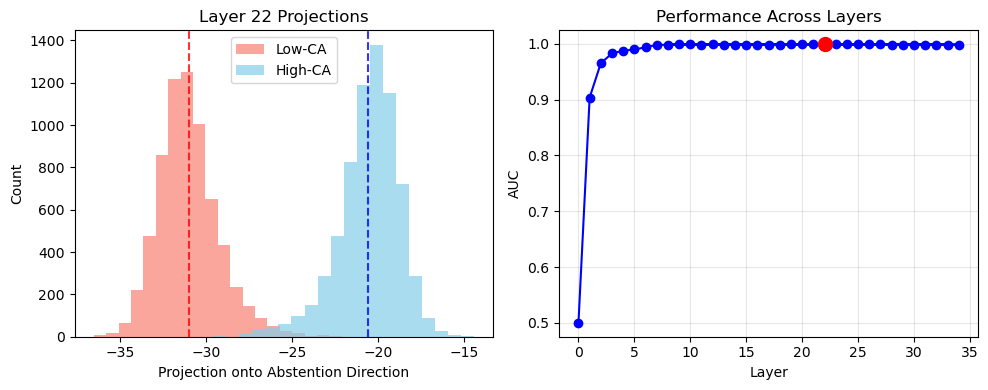

✓ Visualization created


In [13]:
# Optional: Create a simple visualization (if matplotlib available)
try:
    import matplotlib.pyplot as plt

    if best_eval and 'proj_pos' in best_eval:
        plt.figure(figsize=(10, 4))

        # Plot 1: Projection histograms
        plt.subplot(1, 2, 1)
        plt.hist(best_eval['proj_neg'], bins=20, alpha=0.7, label='Low-CA', color='salmon')
        plt.hist(best_eval['proj_pos'], bins=20, alpha=0.7, label='High-CA', color='skyblue')
        plt.axvline(best_eval['mean_neg'], color='red', linestyle='--', alpha=0.8)
        plt.axvline(best_eval['mean_pos'], color='blue', linestyle='--', alpha=0.8)
        plt.xlabel('Projection onto Abstention Direction')
        plt.ylabel('Count')
        plt.title(f'Layer {best_layer} Projections')
        plt.legend()

        # Plot 2: Layer performance comparison
        plt.subplot(1, 2, 2)
        summary_df = direction_analyzer.get_summary_dataframe()
        if len(summary_df) > 1:
            plt.plot(summary_df['layer'], summary_df['auc'], 'bo-', markersize=6)
            plt.scatter([best_layer], [best_eval['auc']], color='red', s=100, zorder=5)
            plt.xlabel('Layer')
            plt.ylabel('AUC')
            plt.title('Performance Across Layers')
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
        print("✓ Visualization created")

except ImportError:
    print("⚠ Matplotlib not available for visualization")
except Exception as e:
    print(f"⚠ Visualization failed: {e}")


## CLI Alternative

You can also run the complete analysis from the command line:

```bash
# Run full analysis on all available data
python scripts/run_fisher_analysis.py

# Analyze specific layers only
python scripts/run_fisher_analysis.py --layers 20 21 22 23 24

# Save detailed summary report
python scripts/run_fisher_analysis.py --save-summary --verbose

# Use custom data directory
python scripts/run_fisher_analysis.py --data-dir ./my_results

# Get help with all options
python scripts/run_fisher_analysis.py --help
```

This provides a complete pipeline from data loading through analysis and reporting, perfect for automated workflows or batch processing.
